In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from xgboost import XGBRegressor
from pyGRNN import GRNN
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

In [2]:
"""
Function that loads and prepares the dataframe. 

Converts the data into time-series readable.
"""
def initialFormat (filepath, indicatorcode):
    #Reads the file and creates a dataframe from it
    df = pd.read_excel(filepath)
    
    #Choose what to forecast using indicator code
    df_icode = df.loc[df['Indicator Code'] == indicatorcode]
    
    #Dropping these columns as they are not needed for the forecast
    df_icode = df_icode.drop(columns=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'])
    
    #Swap axis so it is in the proper format
    df_formatted = df_icode.swapaxes("index", "columns")
    
    #Renaming column name to 'values' to make reference easier
    for col_names in df_formatted.columns:
        name = df_formatted.rename(columns={col_names : "Val"})
        return name
    
    return df_formatted

#9 lines written by me

In [3]:
"""
Refactored from: 

https://cprosenjit.medium.com/10-time-series-forecasting-methods-we-should-know-291037d2e285

"""

def shift_dataframe(data):
    #The value in "shift(-x)" is the lookback period in this case 1.
    data["Target"] = data.Val.shift(-1)
    data.dropna(inplace=True)
    
    return data

#4 lines taken from guide above

In [4]:
"""
line 8 in this function used from: 
https://stackoverflow.com/questions/26921651/how-to-delete-the-last-row-of-data-of-a-pandas-dataframe
"""

def mean_imputation(data):
    filled = data.fillna(data.mean())
    filled.drop(data.tail(1).index,inplace=True) #remove last row
    
    return filled

#3 lines written by me

In [5]:
"""
adapted and modified from: 
https://towardsdatascience.com/time-series-from-scratch-train-test-splits-and-evaluation-metrics-4fd654de1b3
"""

def train_test_split(data):
    
    train = data[:int(len(data)*0.8)]
    test = data[int(len(data) * 0.8):]
    
    return train, test

In [6]:
"""
line 9,10,15 (MDA) adapted and modified from: https://gist.github.com/bshishov/5dc237f59f019b26145648e2124ca1c9

line 12 (MAPE) adapted from: https://www.statology.org/mape-python/
"""

def performance_metrics(y_test, y_pred):
    
    sign1 = np.sign(np.array(y_test[1:]) - np.array(y_test[:-1]))
    sign2 = np.sign(np.array(y_pred[1:]) - np.array(y_pred[:-1]))
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test )) *100
    mae = metrics.mean_absolute_error(y_test, y_pred)
    r2 = metrics.r2_score(y_test, y_pred)
    mda = np.mean((sign1 == sign2).astype(int))
    mean = np.mean(y_test)
    si = (rmse/mean)*100
    
    print("RMSE: ", rmse)
    print("MAPE: ", mape)
    print("MAE: ", mae)
    print("Scatter Index: ", si)
    print("MDA: ", mda)
    print("Mean of actual: ", mean)
    
#15 Lines. 3 From documentation, 3 from github, 9 written by me

In [7]:
"""
Commented out line was the line I used for local testing. Uncommented 'data ='
should be good for universal path

universal path with help from: 

https://stackoverflow.com/questions/50119792/python-import-excel-file-using-relative-path

INDICATOR CODES:

GDP GROWTH = NY.GDP.MKTP.KD.ZG

INFLATION = NY.GDP.DEFL.KD.ZG

UNEMPLOYEMENT MALE = SL.UEM.TOTL.MA.ZS

UNEMPLOYMENT FEMALE = SL.UEM.TOTL.FE.ZS

REAL INTEREST RATE = FR.INR.RINR
"""

#data = initialFormat('/Users/farhanhabibie/Desktop/Farhan Thesis Code /UG-Project-Farhan/Indonesia Macro Dataset.xlsx', 
#                     'NY.GDP.MKTP.KD.ZG')

data = initialFormat(r'./../Indonesia Macro Dataset.xlsx', 'NY.GDP.MKTP.KD.ZG')

filled = mean_imputation(data)
shifted = shift_dataframe(filled)

In [8]:
"""
Written by me
"""

X = shifted.Val.values.reshape(-1,1)
y = shifted.Target.values

In [9]:
"""
Explanation of USING TSCV FROM: 

https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4

[Does literally the same thing as WFV from machine learning mastery]

Code for TSCV from: 

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

slightly modified for my dataset
"""

tscv = TimeSeriesSplit(test_size=len(filled) - int(len(filled)*0.8), n_splits=4)

for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10] TEST: [11 12 13 14 15 16 17 18 19 20 21 22]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] TEST: [23 24 25 26 27 28 29 30 31 32 33 34]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34] TEST: [35 36 37 38 39 40 41 42 43 44 45 46]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46] TEST: [47 48 49 50 51 52 53 54 55 56 57 58]


In [10]:
"""
copied from https://github.com/federhub/pyGRNN

"""

IGRNN = GRNN()
params_IGRNN = {'kernel':["RBF"],
                'sigma' : list(np.arange(0.1, 4, 0.01)),
                #'n_splits' : list(np.arange(2,len(X_train),1)),
                'calibration' : ['none'],
                'method' : ['Nelder-Mead']
                 }
grid_IGRNN = GridSearchCV(estimator=IGRNN,
                          param_grid=params_IGRNN,
                          scoring='neg_mean_squared_error',
                          cv=5,
                          verbose=1
                          )
grid_IGRNN.fit(X_train, y_train)

print("Best hyperparam: ", grid_IGRNN.best_params_)

best_model = grid_IGRNN.best_estimator_
y_pred = best_model.predict(X_test)


Fitting 5 folds for each of 390 candidates, totalling 1950 fits
Best hyperparam:  {'calibration': 'none', 'kernel': 'RBF', 'method': 'Nelder-Mead', 'sigma': 1.6499999999999992}


In [11]:
dtest = data.fillna(data.mean())
dtest.drop(data.tail(1).index, inplace=True)
newindextest = dtest[int(len(data)*0.8):]
newindex = newindextest.index.values.tolist()

RMSE:  0.5871744203541686
MAPE:  6.979868342642585
MAE:  0.3869681368710576
Scatter Index:  10.872963947073995
MDA:  0.6363636363636364
Mean of actual:  5.400316079519256


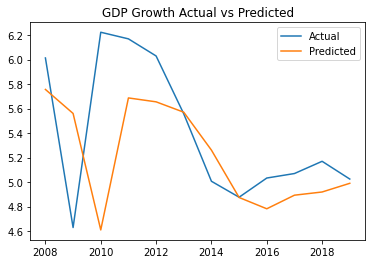

In [12]:
"""
Code written by me, however (line 9) was also used in a previous Introduction to AI Course I partook in,
at City University of London

Link to repository provided: 
https://github.com/LabiKSV/intro-to-ai-farhan-labi/blob/main/Linear%20Regression%20Label%20Encoder.ipynb
"""

df_compare = pd.DataFrame({'Actual' : y_test, 'Predicted' : y_pred})
df_compare.index = newindex
df_compare.plot(title='GDP Growth Actual vs Predicted')
performance_metrics(y_test, y_pred)
#5 lines written by me